Learn the corrected Jacobi iterator (H) for single-phase problems 
* The iterator is shared by different grids 
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the linear

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from functools import reduce

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

In [3]:
n = 2**5
grid = SingleGrid(size=2,n=n)

In [4]:
model_name = 'iso_poisson_33x33'
training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_33x33.h5')
model_dir = 'Model/learn_iterator/iso_poisson'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

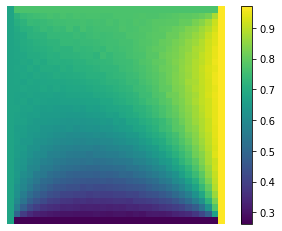

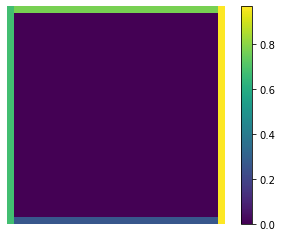

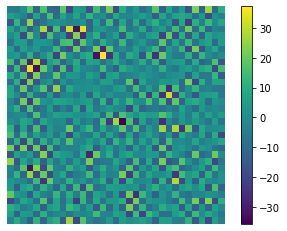

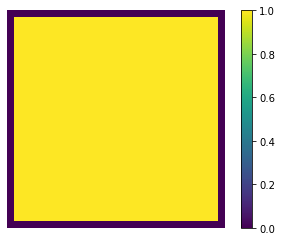

In [5]:
train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=0
plot.plot_field(u_train[k,0])
plot.plot_field(bc_value_train[k,0])
plot.plot_field(f_train[k,0])
plot.plot_field(bc_index_train[k,0])

0 4.5226521492004395
1 3.270998954772949
2 2.609698534011841
3 2.1936986446380615
4 1.904931664466858
5 1.6913220882415771
6 1.5261059999465942
7 1.3940294981002808
8 1.2857226133346558
9 1.1950913667678833
10 1.1179909706115723
11 1.0514973402023315
12 0.9934859871864319
13 0.9423726797103882
14 0.8969512581825256
15 0.856285810470581
16 0.8196385502815247
17 0.786419153213501
18 0.7561498284339905
19 0.7284390330314636
20 0.7029629349708557
21 0.6794508695602417
22 0.6576753854751587
23 0.6374430060386658
24 0.618588924407959
25 0.6009712219238281
26 0.5844671726226807
27 0.5689702033996582
28 0.5543870329856873
29 0.5406360030174255
30 0.5276448726654053
31 0.515349805355072
32 0.5036940574645996
33 0.4926270544528961
34 0.4821036756038666
35 0.47208309173583984
36 0.4625289738178253
37 0.4534081518650055
38 0.4446908235549927
39 0.4363499879837036
40 0.4283609390258789
41 0.420701265335083
42 0.4133504033088684
43 0.40628984570503235
44 0.39950209856033325
45 0.39297157526016235
46

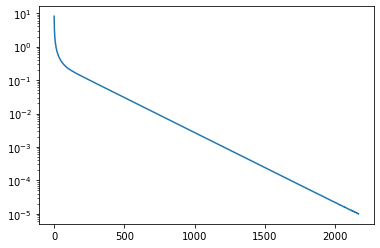

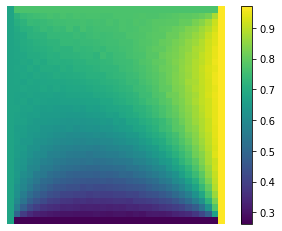

Solution from dataset:


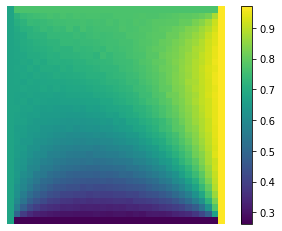

Error (dataset v.s. jacobi):


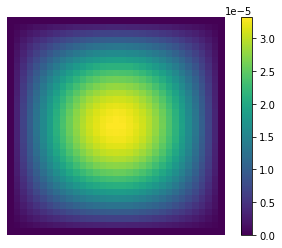

In [6]:
EPS = 1e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_test = grid.jac.reset_boundary(u_test)
residual = f_test-grid.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, f_test)
    residual = f_test-grid.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [7]:
class HNet(nn.Module):
    def __init__(self, nb_layers):
        super(HNet, self).__init__()

        self.convLayers = nn.ModuleList([nn.Conv2d(1, 1, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, x, geo_idx):
        '''geo_idx: internal points 1; boundary points 0'''
        return reduce(lambda acc, el: el(acc) * geo_idx, self.convLayers, x)

In [8]:
class HJacIterator(nn.Module):
    def __init__(self, 
                 size=2, 
                 hnet=None,
                 grid=None,
                 n=2**5,
                 batch_size=5,
                 max_epochs=1000,
                 nb_layers=3,
                 model_dir='Model/learn_iterator/iso_poisson'):
        super(HJacIterator, self).__init__()
        self.size = size
        self.n = n
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n)
        else:
            self.grid = grid

        if(hnet is None):
            self.net = HNet(nb_layers)
        else:
            self.net = hnet

        self.optimizer = torch.optim.Adadelta(self.net.parameters())
        self.model_dir=model_dir

    def HRelax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of modified Jacobi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, f)
            u = jac_it + self.net(jac_it-u, self.grid.jac.geometry_idx)
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            u_train, f_train, bc_value_train, bc_index_train = data
        
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = random.randint(1,20)

            self.grid.ResetBoundary(bc_index_train, bc_value_train)
            ff = self.grid.fnet(f_train)
            uu = self.RandomSampling(f_train)
            
            u_out = self.HRelax(uu, ff, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train


Step-0 loss: 1980.468051147461
Step-50 loss: 252.81372289657594
Step-100 loss: 267.69851212501527
Step-150 loss: 472.804358959198
Step-200 loss: 812.8689831733703
Step-250 loss: 250.47605993747712
Step-300 loss: 333.44605231285095
Step-350 loss: 163.5397805452347
Step-400 loss: 439.6281082391739
Step-450 loss: 823.8697071552276
Step-500 loss: 376.9052553653717
Step-550 loss: 491.39591839313505
Step-600 loss: 720.0152411937713
Step-650 loss: 458.2578382015228
Step-700 loss: 514.6203252553939
Step-750 loss: 739.4717963218689
Step-800 loss: 216.0970344543457
Step-850 loss: 733.200274848938
Step-900 loss: 350.9218149662018
Step-950 loss: 131.62584133148192
Average q:  tensor(408.6361) , STD:  tensor(177.9624)


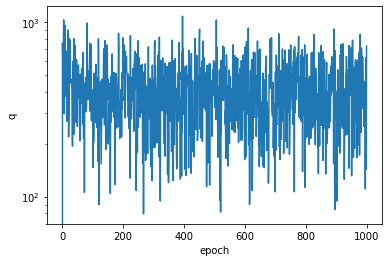

In [9]:
my_iterator = HJacIterator()
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')
print("Average q: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

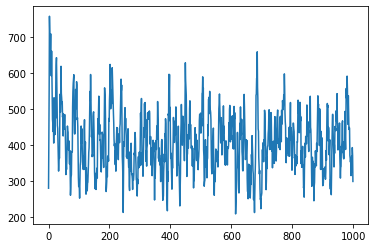

In [20]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

smoothed = movingaverage(loss_train.flatten(), 5)
plt.plot(smoothed)

In [10]:
# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))

In [11]:
# import the learned model
my_hnet = HNet(nb_layers=3)
my_hnet.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = HJacIterator(hnet=my_hnet, grid=grid)

0 8.089801788330078
1 3.606829881668091
2 2.049779176712036
3 1.2721823453903198
4 0.8255615234375
5 0.5491057634353638
6 0.37333112955093384
7 0.26163750886917114
8 0.1916850209236145
9 0.14824138581752777
10 0.12061712145805359
11 0.10198067128658295
12 0.08832597732543945
13 0.07755541056394577
14 0.0686003565788269
15 0.0609176829457283
16 0.05420990660786629
17 0.0482972078025341
18 0.04305803030729294
19 0.03840212523937225
20 0.034257400780916214
21 0.030564291402697563
22 0.027271561324596405
23 0.02433479018509388
24 0.021715134382247925
25 0.01937759853899479
26 0.017292102798819542
27 0.01543095801025629
28 0.013770291581749916
29 0.012288546189665794
30 0.010965957306325436
31 0.009785915724933147
32 0.008732862770557404
33 0.007793141063302755
34 0.006954545620828867
35 0.006206140387803316
36 0.005538138560950756
37 0.004942308180034161
38 0.004410494118928909
39 0.003935952205210924
40 0.003512444207444787
41 0.003134418511763215
42 0.002797054825350642
43 0.002496172906

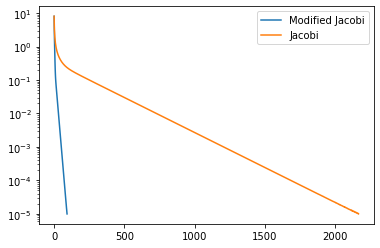

New solution:


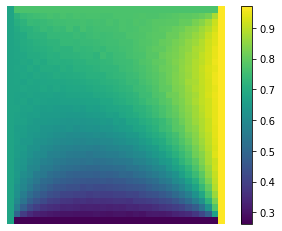

Solution from dataset:


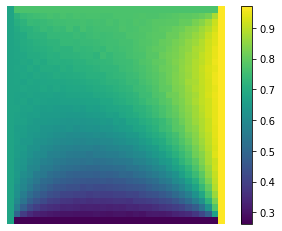

Error (dataset v.s. jacobi):


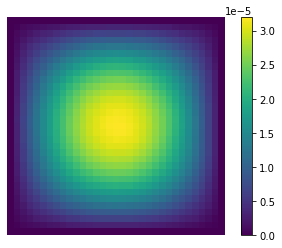

In [12]:
EPS = 1e-5
n_jac_new = 0
u_new = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_new = grid.jac.reset_boundary(u_new)
residual = f_test-grid.Knet(u_new)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_new = [res]
print(n_jac_new, res)
while (abs(res) > EPS):
    n_jac_new += 1
    u_new = new_iterator.HRelax(u_new, f_test, 1)
    residual = f_test-grid.Knet(u_new)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_new.append(res)
    print(n_jac_new, res)

print("Solution converges after", n_jac_new, "modified Jacobi iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

print("New solution:")
plot.plot_field(u_new.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_new.detach().reshape((1,1,n+1,n+1)))

In [13]:
def compute_q(res_arr):
    return res_arr[-1]/res_arr[-2]

In [14]:
EPS = 1e-5
n = 2**5
model = MultiGrid(n, P) # create a new model
n_multigrid = 0
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
#u_mg = random_sampling(f_mg)
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
residual = model.f-model.grids[0].Knet(model.u0)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
err_occured = False
res_arr = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model.iterate(u_mg, model.f)
    residual = model.f-model.grids[0].Knet(u_mg)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

NameError: name 'MultiGrid' is not defined

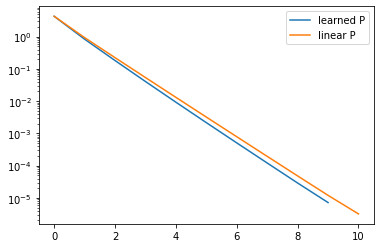

In [ ]:
plt.plot(res_arr, label="learned P")
plt.plot(res_arr_linear, label="linear P")
plt.yscale('log')
plt.legend()
plt.show()

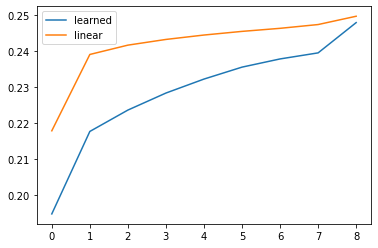

In [ ]:
k = []
k_linear = []
for i in range(len(res_arr)-1):
    k.append(res_arr[i+1]/res_arr[i])
    k_linear.append(res_arr_linear[i+1]/res_arr_linear[i])

plt.plot(k, label = 'learned')
plt.plot(k_linear, label='linear')
plt.legend()

In [ ]:
print("q is: ", compute_q(res_arr))
print("q hat is: " + str(float(model.loss(u_mg, len(res_arr)-1).detach())))

q is:  0.242199529176493
q hat is: 1.6256930166491657e-06


In [ ]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_P)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.1887245923280716
6.571310011737677 0.2010144144296646
1.144095828095757 0.24095818400382996
3.762820113405668 0.2857430875301361
1.285842107227971 0.3394377827644348
2.8855768128300583 0.40330663323402405
1.4101545094683223 0.4792734980583191
2.47634326142357 0.5695580244064331
1.5136780448918956 0.676983654499054
2.2493800225123253 0.8048299551010132
1.5968602055764027 0.9567620754241943
2.1129421822315706 1.1371899843215942
1.6613445405017153 1.351672649383545
2.025374426743576 1.6068735122680664
1.7101370247488619 1.910357117652893
1.9679901033287657 2.270916700363159
1.7466234255282 2.699281692504883
1.9290668723158666 3.2087647914886475
1.7731105053071017 3.8148350715637207
1.9025917223887077 4.5350661277771
1.792657707102398 5.390636920928955
1.8842065802210468 6.407895565032959
1.8064153145950703 7.61809778213501
1.8714270671349325 9.056654930114746
1.816615349465342 10.765520095825195
1.8624827348472983 12.797175407409668
1.8235604961317993 15.214228630065918
1.8562154406

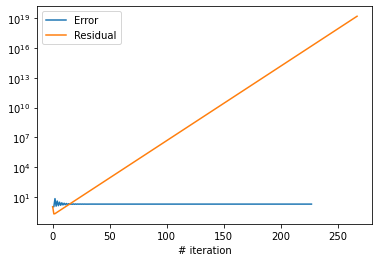

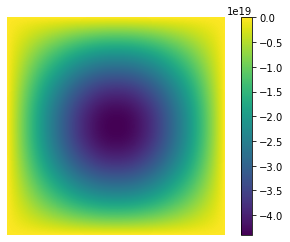

In [ ]:
# Multigrid implementation
n = 2**9
model_mg = MultiGrid(n, P) # create a new model
prob_mg = mgTest(model_mg, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [ ]:
print("q is: ", compute_q(res_arr_Vcycle))

q is:  inf
